In [1]:
import math

import sys
sys.path.append("../../environments/mdp_gridworld/")
from mdptoolbox_wrapper import *
import mdptoolbox
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
book_grid = [[' ',' ',' ',+100],
            [' ','#',' ',-100],
            ['@',' ',' ',' ']]

def run_value_iteration(T, R, gamma, *args, **kwarg):
    T = T.transpose(1,0,2)
    vi = mdptoolbox.mdp.ValueIteration(T, R, gamma, *args, **kwarg)
    vi.run()
    return vi

class GridWorld(object):
    """
    This is a nice approximation for all the complexity of the entire universe 
        –Charles Isbell
    """
    MARKER_WALL = '#'
    MARKER_CURR_STATE = '@'
    MARKER_FREE_SPACE = ' '
    
    def __init__(self, grid, living_reward=-0.01, gamma=0.99, action_noise_dist=[0.1, 0.8, 0.1], use_linear_reward=False, silent=True):
        
        """
        Returns a grid world with input specifications. 
        
        Grid spec: '#' walls, '<int>' terminal state, 'S' initial position, ' ' free space
        """
        
        assert(len(grid) != 0 and len(grid[0]) != 0)
        
        self.grid = grid.copy()
        self.width = len(grid[0])
        self.height = len(grid)
        self.living_reward = living_reward
        self.action_noise_dist = action_noise_dist
        self.actions_name = ["North", "East", "South", "West"]
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.curr_state, self.states = self._compute_states(grid)
        self.nS = len(self.states)
        self.absorbing_state_idx = self.nS-1
        # states_to_idx: Maps state feature (dim=K) to its index(0-N) in the self.states list
        # For reverse mapping we can simply use self.states as it gives state features at a given index
        self.states_to_idx = dict(zip(self.states, range(self.nS)))
        self.nA = len(self.actions)
        self.gamma = gamma
        if use_linear_reward:
            self.R = np.asarray([self.reward_linear(s_idx) for s_idx in range(self.nS)]) # R = f(S)
        else:
            self.R = np.asarray([self.reward(s_idx) for s_idx in range(self.nS)])
        self.T = self.compute_dynamics(self.nS, self.nA, self.R) # f(S, A, S')
        self.mdp_transitions = self.compute_mdp_transitions(self.nS, self.nA, self.R)
        
        # Add class attribute for action strings which evaluates to action index
        for i, a_name in enumerate(self.actions_name):
            setattr(type(self), a_name, i)
            
        # For visualization purpose
        self.silent = silent
        if not self.silent: print(self.get_state_representation_2d(self.curr_state))
            
    def _compute_states(self, grid, feature_type='2d_loc'):
        """
        Returns: Computes number of states in the grid world.
        Input: 
            grid: grid description as python 2d array of strings (Ref: book_grid)
        """
        states = []
        init_state = (0, 0)
        for row in range(self.height): #[::-1]: # all rows, reverse order so that 0th state is (0,0)
            for col in range(self.width): # all cols
                
                # State feature is simply (row#, col#)
                state_feat1, state_feat2 = row, col
                # Walls act like obstacles, and bumping into them won't change state (for now)
                if grid[row][col] != self.MARKER_WALL:
                    if feature_type == '2d_loc':
                        state = (state_feat1, state_feat2)
                    else:
                        raise ValueError("Not Supported feature_type={}!".format(feature_type))

                    states.append(state)

                    if grid[row][col] == self.MARKER_CURR_STATE:
                        init_state = state
        # The absorbing state
        states.append((-1,-1))
        return init_state, states
    
    def _is_terminal(self, s_idx):
        """
        Returns: boolean representing whether a state represented by its index is a terminal
            As per current model, this will be True for grid cells with integer reward value
        """
        r, c = self.states[s_idx]
        return isinstance(self.grid[r][c], int) or isinstance(self.grid[r][c], float)
    
    def reward_linear(self, s_idx):
        
        if s_idx == self.nS-1:
            return 0
        
        r, c = self.states[s_idx]
        return r*10 + c*5
        
    def reward(self, s_idx):
        
        if s_idx == self.nS-1:
            return 0
        
        r, c = self.states[s_idx]
        if isinstance(self.grid[r][c], int) or isinstance(self.grid[r][c], float):
            return float(self.grid[r][c])
        elif self.grid[r][c] == self.MARKER_WALL:
            return -1
        else:
            return self.living_reward
    
    def next_states_with_probs(self, s_idx, a_idx):
        """
        Returns: Returns [(s_prime, p(s_prime)), ...] for given state and stochastic action
        """
        assert(len(self.action_noise_dist) == 3)
        
        state_primes_to_probs = {}
        r, c = self.states[s_idx]
        
        if self.grid[r][c] == self.MARKER_WALL:
            return [(self.nS-1, 1.)]
        
        for j, noisy_a_idx in enumerate([a_idx-1, a_idx, (a_idx+1)%self.nA]): # hard coded for len(self.action_noise_dist) == 3
            
            dr, dc = self.actions[noisy_a_idx]
            p = self.action_noise_dist[j]
            new_r, new_c = r+dr, c+dc
            if new_r < 0 or new_r >= self.height \
                or new_c < 0 or new_c >= self.width \
                or self.grid[new_r][new_c] == self.MARKER_WALL:
                    new_r, new_c = r, c
                    
            if self.states_to_idx[(new_r, new_c)] in state_primes_to_probs:
                state_primes_to_probs[self.states_to_idx[(new_r, new_c)]] += p
            else:
                state_primes_to_probs[self.states_to_idx[(new_r, new_c)]] = p
            
        return state_primes_to_probs.items()
    
    def compute_dynamics(self, nS, nA, R):
        
        absorbing_state_idx = nS-1
        T = np.zeros((nS, nA, nS))
        
        for s_idx in range(nS): # no transitions from absorbing state
            for a_idx in range(nA):
                
                if s_idx == absorbing_state_idx:
                    T[s_idx, a_idx, absorbing_state_idx] = 1.
                elif self._is_terminal(s_idx):
                    T[s_idx, a_idx, absorbing_state_idx] = 1.
                else:
                    for k, (s_prime_idx, next_p) in enumerate(self.next_states_with_probs(s_idx, a_idx)):
                        T[s_idx, a_idx][s_prime_idx] = next_p
        return T
    
    def compute_mdp_transitions(self, nS, nA, R):
        """
        Computes and Returns: MDP Transitions T{s}{a} = (p, s_prime, r, done) for all s, a, s_prime
        """
        mdp = {}
        absorbing_state_idx = nS-1
        
        for s_idx in range(nS-1): # no transitions from absorbing state
        
            mdp[s_idx] = {}
            for a_idx in range(nA):
                if self._is_terminal(s_idx):
                    # Terminal state reward is achieved on transitioning to absorbing state
                    mdp[s_idx][a_idx] = [(1., absorbing_state_idx, 0., False)] 
                else:
                    mdp[s_idx][a_idx] = []
                    for k, (s_prime_idx, next_p) in enumerate(self.next_states_with_probs(s_idx, a_idx)):
                        mdp[s_idx][a_idx].append((next_p, s_prime_idx, R[s_prime_idx], False))
        
        # Absorbing state
        mdp[absorbing_state_idx] = {a_idx: [(1., absorbing_state_idx, 0., True)] for a_idx in range(nA)}
        return mdp
    
    def get_transition_dynamics_T(self):
        """
        Returns: 3D MDP transition dynamics T[s, a, s']
        """
        return self.T.copy()
        
    def __get_optimal_policy(self):
        """
        Returns: Optimal Policy Pi(s) for all s
        """
        if 'vi_results' not in dir(self):
            self.vi_results = run_value_iteration(self.T, self.R, self.gamma)
            
        return np.asarray(self.vi_results.policy).copy()
        
    def get_possible_actions(self, s_idx):
        
        if self._is_terminal(s_idx):
            return None
        
        return self.actions.copy()
    
    def get_state_2d_features_matrix(self):
        """
        Returns: State feature matrix of size N x K, N is number of states and K is dimensionality of state features
        """
        return np.asarray(self.states).copy()
    
    def get_state_grid_features_matrix(self):
        """
        Returns: State feature matrix of size N x K, N is number of states and K is dimensionality of state features
        """
        return np.asarray([self.state_idx_to_feature(s) for s in range(self.nS)])
    
    def move(self, a_idx):
        """
        Takes stochastic action speified by a_idx in curr_state of the object and modifies curr_state with the resulting state
        """
        s_idx = self.states_to_idx[self.curr_state]
        s_prime_idx = self.act(s_idx, a_idx)
        self.curr_state = self.states[s_prime_idx]
        if not self.silent: print(self.get_state_representation_2d(self.curr_state))

    def act(self, s_idx, a_idx):
        """
        Returns: the next state (index) from executing stochastic a_idx in s_idx
        """
        return np.random.choice(range(self.nS), p=self.T[s_idx, a_idx])
    
    def sample_trajectories(self, M, init_state_idx="random", max_length=100, Pi="optimal", padding=True):
        """
        Samples and returns T trajectories of the form 
            [ [(s0_0, a0_0, r0_0), ..., (s0_T, a0_T, r0_T)], [(s1_0, a1_0, r1_0), ..., (s1_T, a1_T, r1_T)], 
                                                ... [(sM_0, aM_0, rM_0), ..., (sM_T, aM_T, rM_T)]]
        Input:
            M: # of trajectories to be sampled
            init_state_idx: initial state s0, if assigned "random" it'll randomly sample starting state
            max_length: maximum length of the trajectory
            padding: If trajectory (walk over DAG) terminates before encountering max_length states, it'll pad the last (s,a,r)
            Pi: Policy. Mapping of state_idx to action_idx of size N, where N is number of states.
            
        """
        tau_list = []
        
        for _ in range(M):
            tau_list.append(self.sample_trajectory(init_state_idx, max_length, Pi, padding))
        return tau_list
    
    def state_idx_to_feature(self, s_idx):
        return np.eye((self.nS))[s_idx].tolist()
    
    def get_valid_random_state(self):
        
        s_idx = np.random.randint(self.nS-1)
        r, c = self.states[s_idx]
        while self.grid[r][c] == self.MARKER_WALL:
            return self.get_valid_random_state()
        return s_idx
    
    def sample_trajectory(self, init_state_idx="random", max_length=100, Pi="optimal", behavior_optimality=0.8, padding=True):
        """
        Samples a trajectory of the form [(s0, a0, r0), ..., (sT, aT, rT)]
        Input:
            init_state_idx: initial state s0, if assigned "random" it'll randomly sample starting state
            max_length: maximum length of the trajectory
            padding: If trajectory (walk over DAG) terminates before encountering max_length states, it'll pad the last (s,a,r)
            Pi: Policy. Mapping of state_idx to action_idx of size N, where N is number of states.
                Two special values:
                    - "random" will initialize a random policy
                    - "optimal" will use the optimal policy for the given MDP (currently using policy iteration)
        """
        tau = []
        absorbing_state_idx = self.nS-1
        
        if init_state_idx == "random":
            s_idx = self.get_valid_random_state() #np.random.randint(self.nS-1)
        else:
            s_idx = init_state_idx
            
        if Pi == "random":    
            Pi = np.random.choice(self.nA, size=self.nS-1)
        elif Pi == "optimal":
            Pi = self.__get_optimal_policy()
        else:
            pass
        
        for i in range(max_length):
            
            if behavior_optimality < 1:
                if np.random.random() <= behavior_optimality:
                    a_idx = Pi[s_idx]
                else:
                    a_idx = np.random.choice(self.nA)
            else:
                a_idx = Pi[s_idx]
                
            s_prime_idx = self.act(s_idx, a_idx)
            tau.append((s_idx, a_idx, self.R[s_prime_idx]))
            if s_idx == self.nS-1: #self._is_terminal(s_idx):
                # Reached terminal state, terminate trajectory here
                break
            s_idx = s_prime_idx
        
        if padding:
            for j in range(i, max_length):
                tau.append((s_idx, a_idx, self.R[s_prime_idx]))
        return tau
    
    def interpret_trajectory(self, tau):
        
        for (s_idx, a_idx, r) in tau:
            print("s:")
            print(self.get_state_representation_2d(self.states[s_idx]))
            print("a: ", self.actions_name[a_idx])
            print("r: ", r) # Note: this is current state reward
    
    def disp_custom_grid(self, state_values, formatting=lambda x: "{:+.3f}".format(x), display_absorbing=True):
        
        """
        Returns: state_values representation of states
        Input: state_values associated with each state
        """
        self.state_values_dict = {self.states[i]: state_values[i] for i in range(len(state_values))}
        
        msg = ''
        cell_filler = "_"
        grid = self.grid
        for r in range(self.height):
            for c in range(self.width):
                if grid[r][c] != self.MARKER_WALL:
                    tt = formatting(self.state_values_dict[(r,c)])
                else: # Show unreachable states (such as Walls) with -inf
                    tt = str(np.float("-inf"))
                msg += tt + "\t" #"{txt:{fill}^5s}".format(txt=tt, fill=cell_filler)
            msg += "\n"
        
        if display_absorbing and len(state_values) == self.nS:
            msg += "Absorbing state: " + formatting(state_values[-1])
        print(msg)
        
    def get_state_representation_2d(self, state):
        
        msg = ''
        cell_filler = "_"
        grid = self.grid
        curr_r, curr_c = state
        for r in range(self.height):
            for c in range(self.width):
                if r == curr_r and c == curr_c:
                    tt = self.MARKER_CURR_STATE
                elif grid[r][c] == self.MARKER_FREE_SPACE\
                    or (grid[r][c] == self.MARKER_CURR_STATE and (r != curr_r or c != curr_c)):
                    tt = cell_filler
                else:
                    if isinstance(grid[r][c], int) or isinstance(grid[r][c], float):
                        tt = "{:+d}".format(grid[r][c])
                    else:
                        tt = grid[r][c]
                msg += "{txt:{fill}^5s}\t".format(txt=tt, fill=cell_filler)
            msg += "\n"
        return msg
    
    def __str__(self):
        return self.get_state_representation_2d(self.curr_state)

In [3]:
gw = GridWorld(book_grid, action_noise_dist=[0.1,0.8,0.1], silent=False, gamma=0.99)

_____	_____	_____	+100_	
_____	__#__	_____	-100_	
__@__	_____	_____	_____	



In [4]:
gw.move(GridWorld.North)

_____	_____	_____	+100_	
__@__	__#__	_____	-100_	
_____	_____	_____	_____	



In [5]:
# print(gw.mdp.transitions[:, :, :]) # A x S x S'
# print(gw.T)
gw.T[0] # S X A X (P(s'), s', R(s'), Done)

array([[0.9, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.8, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.9, 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [6]:
print("States (fused into a single grid-bc it's possible to do so here):")
gw.disp_custom_grid(range(gw.nS), formatting=lambda x: str(x))

States (fused into a single grid-bc it's possible to do so here):
0	1	2	3	
4	-inf	5	6	
7	8	9	10	
Absorbing state: 11


In [7]:
vi = run_value_iteration(gw.get_transition_dynamics_T(), gw.R, gw.gamma)

In [8]:
gw.disp_custom_grid(vi.V, formatting=lambda x: "{:.2f}".format(x))

95.12	96.48	97.71	100.00	
93.92	-inf	89.38	-100.00	
92.59	91.42	90.17	81.81	
Absorbing state: 0.00


In [9]:
print("Policy:")
gw.disp_custom_grid(vi.policy, lambda x: "{:}".format(gw.actions_name[x]))

Policy:
East	East	East	North	
North	-inf	West	North	
North	West	West	South	
Absorbing state: North


## Sampling Trajectories

In [10]:
tau = gw.sample_trajectory(init_state_idx=7, max_length=5)
print(tau)

[(7, 0, -0.01), (4, 1, -0.01), (4, 0, -0.01), (4, 0, -0.01), (0, 1, -0.01), (4, 1, -0.01)]


In [11]:
gw.interpret_trajectory(tau)

s:
_____	_____	_____	+100_	
_____	__#__	_____	-100_	
__@__	_____	_____	_____	

a:  North
r:  -0.01
s:
_____	_____	_____	+100_	
__@__	__#__	_____	-100_	
_____	_____	_____	_____	

a:  East
r:  -0.01
s:
_____	_____	_____	+100_	
__@__	__#__	_____	-100_	
_____	_____	_____	_____	

a:  North
r:  -0.01
s:
_____	_____	_____	+100_	
__@__	__#__	_____	-100_	
_____	_____	_____	_____	

a:  North
r:  -0.01
s:
__@__	_____	_____	+100_	
_____	__#__	_____	-100_	
_____	_____	_____	_____	

a:  East
r:  -0.01
s:
_____	_____	_____	+100_	
__@__	__#__	_____	-100_	
_____	_____	_____	_____	

a:  East
r:  -0.01


In [12]:
tau_list = gw.sample_trajectories(10, max_length=10)
for i, tau in enumerate(tau_list): print("T{:03d}: {}".format(i, tau))

T000: [(5, 3, -0.01), (9, 3, -0.01), (9, 3, -0.01), (8, 3, -0.01), (7, 0, -0.01), (4, 0, -0.01), (0, 1, -0.01), (0, 1, -0.01), (1, 1, -0.01), (2, 1, -0.01), (2, 1, -0.01)]
T001: [(3, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0)]
T002: [(5, 3, -0.01), (5, 3, -0.01), (5, 3, -0.01), (5, 3, -0.01), (5, 3, -0.01), (5, 3, -0.01), (2, 1, 100.0), (3, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0)]
T003: [(4, 0, -0.01), (4, 0, -0.01), (0, 1, -0.01), (0, 1, -0.01), (1, 1, -0.01), (2, 1, 100.0), (3, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0)]
T004: [(1, 1, -0.01), (1, 1, -0.01), (1, 1, -0.01), (2, 1, 100.0), (3, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0), (11, 0, 0.0)]
T005: [(5, 3, -0.01), (9, 3, -0.01), (8, 3, -0.01), (8, 3, -0.01), (7, 0, -0.01), (4, 0, -0.01), (0, 1, -0.01), (1, 1, -0.01), (2, 1, -0.01), (2, 1, 100.0), (3, 1, 100.0)]

## MDP ToolBox

In [13]:
gw = GridWorld(book_grid, action_noise_dist=[0.1,0.8,0.1])
initial_policy = np.random.choice(gw.nA, size=gw.nS)
pi = mdptoolbox.mdp.ValueIteration(
    gw.T.copy().transpose(1,0,2),
    gw.R,
    gw.gamma
)
# pi.setSilent()
pi.run()

In [14]:
gw.disp_custom_grid(pi.V, lambda x: "{:.2f}".format(x))

95.12	96.48	97.71	100.00	
93.92	-inf	89.38	-100.00	
92.59	91.42	90.17	81.81	
Absorbing state: 0.00


In [15]:
gw.disp_custom_grid(pi.policy, lambda x: "{:}".format(gw.actions_name[x]))

East	East	East	North	
North	-inf	West	North	
North	West	West	South	
Absorbing state: North


## MDP Visualization

In [16]:
import pydot
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import tempfile

def disp_mdp(mdp_js, V):
    
    tmp_img = tempfile.mktemp()
    G=nx.DiGraph()
    for s in mdp_js['states']:
        for a in s['actions']:
            for t in a['transitions']:
                ecolor='red' if a['id'] else 'green'
                elabel='p={}, r={}'.format(round(t['probability'],4), t['reward'])
                G.add_edge(s['id'], t['to'],
                        color=ecolor,
                        label=elabel)
    
    mapping = {g: str(g) + ", " + str(g) for g in G}
    # print(mapping)
    G = nx.relabel_nodes(G,  mapping)
    # print(G.nodes())
    pos=nx.fruchterman_reingold_layout(G)
    # nx.draw_networkx_edges(G,pos,width=8,alpha=0.5,edge_color='b')
    # nx.draw(G,with_labels=True)
    write_dot(G, tmp_img)
    g = pydot.graph_from_dot_file(tmp_img)[0]
    g.write_png(tmp_img)
    img = plt.imread(tmp_img)

    plt.figure(figsize=(30,20))
    plt.imshow(img)
    plt.axis("off")

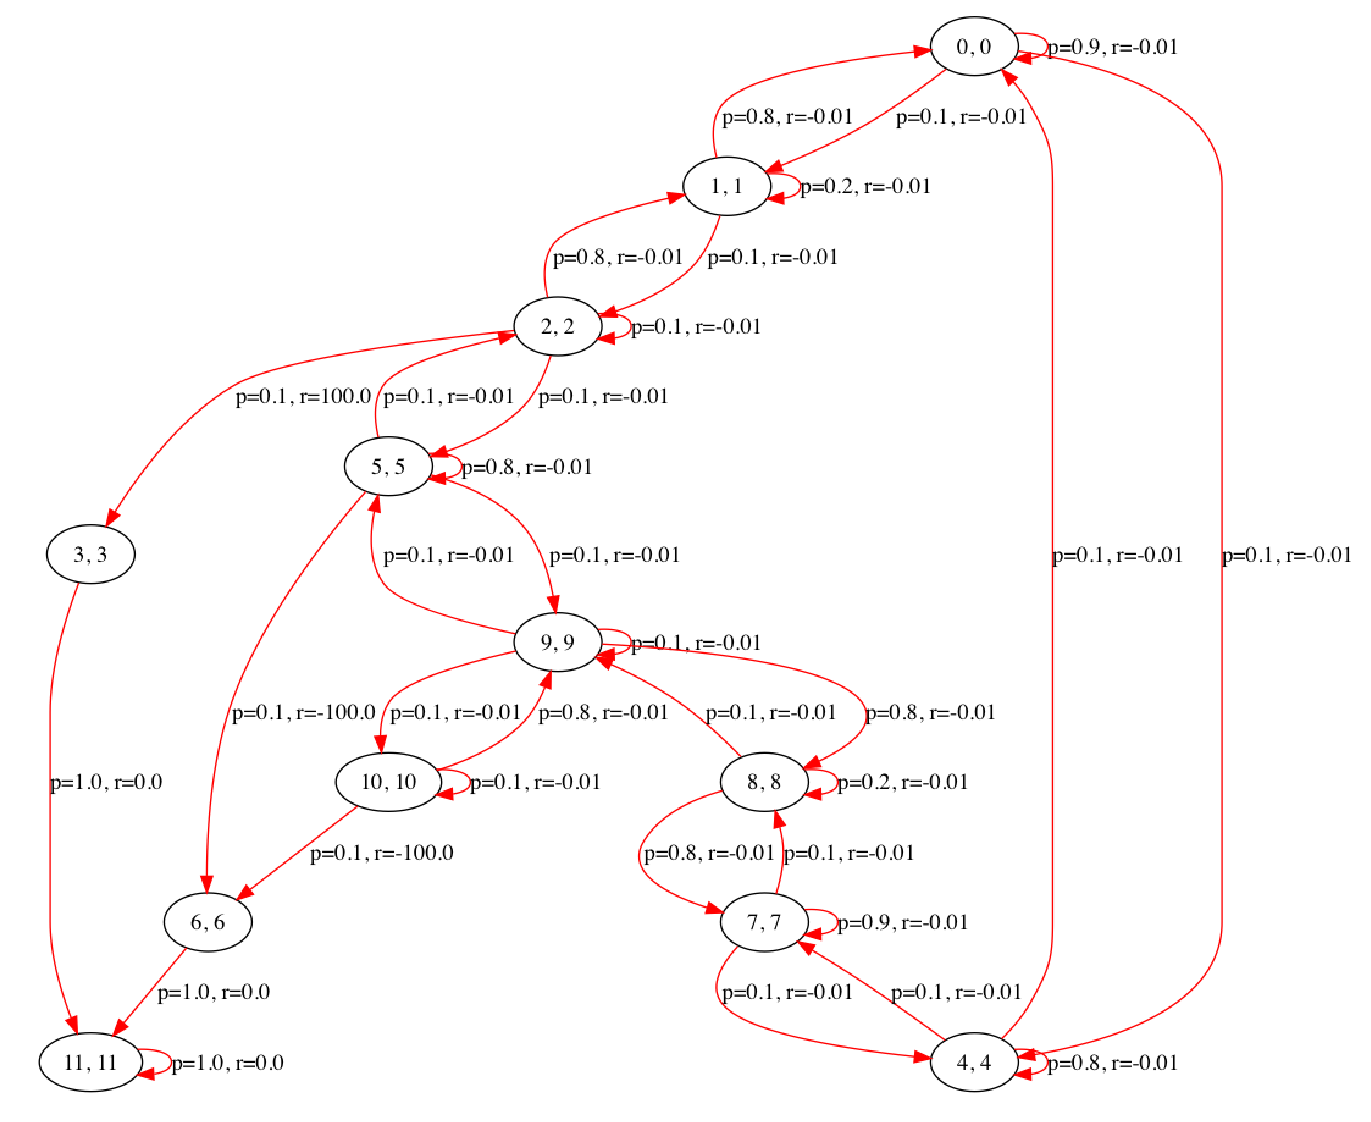

In [17]:
disp_mdp(create_MDP(gw.compute_mdp_transitions(gw.nS, gw.nA, gw.R), gw.gamma), pi.V)

# Inferring rewards from suboptimal expert demonstrations

**Inverse Reinfrocement Learning:**  
In RL framework, reward is the most succinct representation of the state that governs the animal behavior. Once we know the reward for each state as well as dynamics, we can recover optimal behavior (policy) easily.  

The key problem that inverse reinforcement learning tries to address is to infer reward function from the demonstrations. Once it is recovered (inferred), a machine can optimize over it and produce the desired behavior and hopefully transfer that knowledge efficiently to the new domains. To do this efficiently, we would ideally need optimal demonstrations performed by some expert, however, we cannot ignore suboptimality in the expert behavior. There are solid reasons why we must not ignore it. First, the ultimate objective is to help machine infer rewards and intentions of the people or species they are interacting with, so that they can not only clone the behavior but also transfer that knowledge and behave approximately similarly in different situations (domains). Most demonstrations will be performed by humans/animals who don't act optimally in every scenario (Add citations). Second, we have not yet succeeded in determining laws that govern all physical processes, so there's always inherent randomness and noise in any system that we must account for, the expectation of suboptimality also helps us sweep our ignorance under the rug for the time being while we are making progress towards being less ignorant.


In [18]:
def q_values(v, nA, reward, T, gamma):
    
    nS = len(v)
    Q = np.zeros((nS, nA))
    for si in range(nS):
        for ai in range(nA):
            # Better stochastic model (Ziebart et al., 2010). Received from: https://youtu.be/iOYiPhu5GEk?t=33m56s.
            # Q = expectation of (reward(next_state) + value(next_state)) over next_state
            Q[si, ai] =  T[si, ai].dot(reward[si] + gamma*v)
    Q -= Q.max(axis=1).reshape((nS,1)) # We'll use exp of this value for Beta (backward message) so for numeric stability we lower it's scale
    return Q

def get_v_from_q(Q, nS, nA):
    
    V = np.zeros((nS))
    for si in range(nS):
        for ai in range(nA):
            V[si] += np.exp(Q[si, ai])
    return np.log(V)

In [19]:
vi = run_value_iteration(gw.T, gw.R, gw.gamma)
Q = q_values(np.asarray(vi.V), gw.nA, gw.R, gw.T, gw.gamma)
V = get_v_from_q(Q, gw.nS, gw.nA)

In [20]:
def s_a_backward_message(Q,s,a):
    return np.exp(Q[s,a])

In [21]:
def s_only_backward_message(V,s):
    return np.exp(V[s])

In [22]:
s_a_backward_message(Q, 0, 0)

0.4377098995324904

In [23]:
s_only_backward_message(V, 0)

1.946781559623239

In [24]:
stochastic_policy = lambda a, s: s_a_backward_message(Q, s, a) / s_only_backward_message(V, s)
pi = np.zeros((gw.nS, gw.nA))
for s in range(gw.nS):
    for a in range(gw.nA):
        pi[s][a] = stochastic_policy(a,s)
#         print(s, a, stochastic_policy(a,s))

In [25]:
pi.argmax(axis=1)

array([1, 1, 1, 0, 0, 3, 0, 0, 3, 3, 2, 0])

In [26]:
pi.max(axis=1)

array([0.51366831, 0.5339523 , 0.67753521, 0.25      , 0.52644767,
       0.99999785, 0.25      , 0.50651923, 0.51693151, 0.76630496,
       0.99999497, 0.25      ])

In [27]:
gw.disp_custom_grid(range(gw.nS), formatting=lambda x: str(x))

0	1	2	3	
4	-inf	5	6	
7	8	9	10	
Absorbing state: 11


In [28]:
gw.disp_custom_grid([gw.actions_name[a] for a in pi.argmax(axis=1)], formatting=lambda x: str(x))

East	East	East	North	
North	-inf	West	North	
North	West	West	South	
Absorbing state: North


In [29]:
print("Probability of optimal action:")
gw.disp_custom_grid(pi.max(axis=1), formatting=lambda x: "{:.2f}".format(x))

Probability of optimal action:
0.51	0.53	0.68	0.25	
0.53	-inf	1.00	0.25	
0.51	0.52	0.77	1.00	
Absorbing state: 0.25


In [30]:
def compute_stochastic_policy(nS, nA, R, T, gamma):
    
    vi = run_value_iteration(T, R, gamma)
    Q = q_values(np.asarray(vi.V), nA, R, T, gamma)
    V = get_v_from_q(Q, gw.nS, gw.nA)
    pi = np.zeros((gw.nS, gw.nA))
    
    for s in range(gw.nS):
        for a in range(gw.nA):
            pi[s][a] = s_a_backward_message(Q, s, a) / s_only_backward_message(V, s)
    return pi

In [31]:
pi_s = compute_stochastic_policy(gw.nS, gw.nA, gw.R, gw.T, gw.gamma)

In [32]:
pi_s.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# MaxEntropy IRL

## Feature Expectations

In [33]:
def compute_feature_expectations(trajectories, state_idx_to_features, gamma, exclude_absorbing_state=True):
    
    """
    Computes and returns: μ(π) from trajectories
    The expectation is taken with respect to the random state sequence s0, s1, ... drawn by starting from a state s0 ∼ D, 
    and picking actions according to unknown π.
    
    Input:
        trajectories: 3D numpy matrix of size M x T x 3, where M is number of trajectories, 
                        T is fixed length of the trajectory (padded with last state if terminated early), 3 is for (s, a, r)
        state_idx_to_features: 2D numpy matrix mapping state index to its features of size N x K, 
                        N is total # of known states and K is its feature dimensionality
    """
    nS, dimS = state_idx_to_features.shape
    feature_expectations = np.zeros((dimS,))
    
    for trajectory in trajectories:
        for i, (s_idx, a_idx, _) in enumerate(trajectory): # we ignore rewards because that's assumed to be unknown
            if exclude_absorbing_state and s_idx == nS-1:
                break
            feature_i = state_idx_to_features[s_idx]
            # Assuming R is a linear combination of known features of the state s, R(s) = w . Phi(s)
            feature_expectations += feature_i #* (gamma**i)
    return feature_expectations / trajectories.shape[0]

In [34]:
gw = GridWorld(book_grid, gamma=0.95, action_noise_dist=[0., 1., 0.])
trajectories_mat = np.asarray(gw.sample_trajectories(5000, init_state_idx="random", max_length=15), dtype=np.int)

In [35]:
# for i, tau in enumerate(gw.sample_trajectories(10, init_state_idx=0, max_length=20)): print("T{:03d}: {}".format(i, tau))

In [36]:
compute_feature_expectations(trajectories_mat, gw.get_state_grid_features_matrix(), gw.gamma, gw._is_terminal)

array([0.2708, 0.367 , 0.8142, 0.9012, 0.1778, 0.362 , 0.0988, 0.0912,
       0.089 , 0.2744, 0.0958, 0.    ])

## State Visitation Frequency
Forward pass

In [37]:
def compute_state_visitation_frequency(trajectories, nS, nA, dynamics_T, R, gamma, silent=True):
    """
    Computes state visitation frequency using forward algorithm, uses DP algorithm from Zeibart et. al (2008).
    
    p(s, t+1) = sum_s' sum_a ( p(s', t-1) * p(a|s') * p(s|s', a))
    i.e., Prob. of being in state at time t+1 = sum over all prev state and actions ( 
                                            probability of being in prev state at time t-1 * probability of taking action a in prev state 
                                            * transition dynamics (state | prev state, action))
    The problem is we don't know p(s) at any time, so we start from p(s0) which can be easily computed from seeing first state of trajectories
    and dividing by number of trajectories (M). Once we have p(s,0) for all s, we can build up p(s,t) using DP. Iteratively compute p(s,t+1) 
    from previously computed p(s, t-1), all we need is policy that affects the state evolution along with dynamics for stochastic actions.  
    
    Ref: DPV chapter 7 on DP
    """
    
    M, T, _ = trajectories.shape
    state_idxs = range(nS)
    action_idxs = range(nA)
    
    # compute stochastic policy
    policy = compute_stochastic_policy(nS, nA, R, dynamics_T, gamma)
    if not silent: print("Stochastic Pi[a|s]: \n [N, E, S, W]"), print(policy), gw.disp_custom_grid([gw.actions_name[a] for a in policy.argmax(axis=1)], formatting=lambda x: str(x))
    
    init_state_idxs = trajectories[:,0,0] # take first visited state from all trajectories
    t0_visitation_count, _ = np.histogram(init_state_idxs, bins=range(nS+1)) # n bins will get counts for n-1 states
    mu_0_s = t0_visitation_count / float(M) # mu_0_s = p(s0 = s), consider s1 and mu_1 if you're a 1 based indexing fan
    mu_t_s = np.zeros((T, nS))
    mu_t_s[0, :] = mu_0_s
    
    for t in range(1,T):
        if not silent: print("Prob of being in states at t =", t-1)
        if not silent: gw.disp_custom_grid(mu_t_s[t-1, :], formatting=lambda x: "{:.3f}".format(x))
        for s_idx in state_idxs[:-1]:  # don't include absorbing state
            for a_idx in action_idxs:
                for s_prev_idx in state_idxs[:-1]: # don't include absorbing state
                    # print(s_prev_idx, "-", a_idx, "->", s_idx,  ":", mu_t_s[t-1, s_prev_idx], "-", policy[s_prev_idx][a_idx], "->", dynamics_T[s_prev_idx, a_idx, s_idx])
                    # visitation freq of s = sum over all s' and a (
                    # prob of being in prev state P(s') * action prob under given policy P(a|s') * probability of transitioning to s P(s',a,s))
                    mu_t_s[t, s_idx] += mu_t_s[t-1, s_prev_idx] * policy[s_prev_idx][a_idx] * dynamics_T[s_prev_idx, a_idx, s_idx]
            
    # Each t represents the probability of reaching a particular state at time step t in a trajectory
    # We can expect it to drop for states that are less rewarding, and stay stable or steadily increase
    # summing up along t gives us total state visitation frequency for max length of trajetory
    return mu_t_s.sum(axis=0) 

In [38]:
# policy = compute_stochastic_policy(gw.nS, gw.nA, gw.R, gw.get_transition_dynamics_T(), gw.gamma)

In [39]:
svf = compute_state_visitation_frequency(trajectories_mat, gw.nS, gw.nA, gw.get_transition_dynamics_T(), gw.R, gw.gamma)
gw.disp_custom_grid(svf, formatting=lambda x: "{:.2f}".format(x))

0.23	0.33	0.82	0.90	
0.14	-inf	0.41	0.10	
0.09	0.14	0.32	0.10	
Absorbing state: 0.00


In [40]:
def max_ent_irl(trajectories, state_idx_to_features, gamma, nA, dynamics_T, n_epochs, alpha, silent=True):
    
    augmented_feature_matrix = state_idx_to_features
    
    M, T, _ = trajectories.shape
    nS, dimS = augmented_feature_matrix.shape
    
    # initialize weights
    theta = np.random.uniform(size=(dimS,)) #np.random.normal(size=(dimS,))
        
    # calculate expert feature expectations
    feature_expectations = compute_feature_expectations(trajectories, augmented_feature_matrix, gamma)
    
    # run gradient descent on theta to minimize difference between observed feature expectations and 
    # state visitation frequency for current (evolving) reward (parameterized by theta and T) function
    for i in range(n_epochs):
        
        curr_R = augmented_feature_matrix.dot(theta)
        svf = compute_state_visitation_frequency(trajectories, nS, nA, dynamics_T, curr_R, gamma, silent=True)
        grad = feature_expectations - augmented_feature_matrix.T.dot(svf)
#         if not silent: print(" theta:", [round(t,4) for t in theta])
#         if not silent: print(" grad:", [round(t,4) for t in grad],)
        theta += alpha * grad
    
    R = augmented_feature_matrix.dot(theta).reshape((nS,))
    R[-1] = 0 # ignore absorbing state reward
    return R

In [41]:
R = max_ent_irl(trajectories_mat, gw.get_state_grid_features_matrix(), gw.gamma, gw.nA, gw.T, 200, 0.1, silent=False)

In [42]:
print("Recovered R:")
gw.disp_custom_grid(R, formatting=lambda x: "{:.2f}".format(x))

Recovered R:
-1.53	-1.86	-1.29	3.50	
-1.20	-inf	-1.35	-2.49	
-1.14	-2.31	-1.34	-1.44	
Absorbing state: 0.00


In [43]:
print("Recovered Policy:") 
vi = run_value_iteration(gw.T, R, gw.gamma)
gw.disp_custom_grid(vi.policy, lambda x: "{:}".format(gw.actions_name[x]))

Recovered Policy:
East	East	East	North	
North	-inf	North	North	
North	East	North	West	
Absorbing state: North


In [44]:
print("Recovered Value:")
vi = run_value_iteration(gw.T, R, gw.gamma)
gw.disp_custom_grid(vi.V, lambda x: "{:.2f}".format(x))

Recovered Value:
-1.46	0.07	2.03	3.50	
-2.58	-inf	0.59	-2.49	
-3.59	-3.06	-0.78	-2.18	
Absorbing state: 0.00


In [45]:
print("True R:")
gw.disp_custom_grid(gw.R, formatting=lambda x: "{:.2f}".format(x))

True R:
-0.01	-0.01	-0.01	100.00	
-0.01	-inf	-0.01	-100.00	
-0.01	-0.01	-0.01	-0.01	
Absorbing state: 0.00


In [46]:
print("Optimal Value:")
vi = run_value_iteration(gw.T, gw.R, gw.gamma)
gw.disp_custom_grid(vi.V, lambda x: "{:.2f}".format(x))

Optimal Value:
85.71	90.23	94.99	100.00	
81.41	-inf	90.23	-100.00	
77.33	81.41	85.71	81.41	
Absorbing state: 0.00


In [47]:
print("Optimal Policy:")
vi = run_value_iteration(gw.T, gw.R, gw.gamma)
gw.disp_custom_grid(vi.policy, lambda x: "{:}".format(gw.actions_name[x]))

Optimal Policy:
East	East	East	North	
North	-inf	North	North	
North	East	North	West	
Absorbing state: North


In [48]:
gw.disp_custom_grid(range(gw.nS), formatting=lambda x: str(x))

0	1	2	3	
4	-inf	5	6	
7	8	9	10	
Absorbing state: 11


## Testing

### Simple Test

In [49]:
test_grid2 = [[' ',' ',' ',' ',+100, ' ',' ',' ',' ']]
gw = GridWorld(test_grid2, gamma=0.99, action_noise_dist=[0., 1., 0.], living_reward=0)
trajectories_mat = np.asarray(gw.sample_trajectories(10000, init_state_idx="random", max_length=10), dtype=np.int)

In [50]:
f_exp = compute_feature_expectations(trajectories_mat, gw.get_state_grid_features_matrix(), gw.gamma)
# print(list(zip(range(gw.nS), f_exp)))
gw.disp_custom_grid(f_exp, formatting=lambda x: "{:.3f}".format(x))

0.113	0.226	0.335	0.440	1.000	0.455	0.342	0.223	0.115	
Absorbing state: 0.000


In [51]:
svf = compute_state_visitation_frequency(trajectories_mat, gw.nS, gw.nA, gw.get_transition_dynamics_T(), gw.R, gw.gamma, False)
print("SVF: "), 
gw.disp_custom_grid(svf, formatting=lambda x: "{:.3f}".format(x))

Stochastic Pi[a|s]: 
 [N, E, S, W]
[[0.1781498  0.4655506  0.1781498  0.1781498 ]
 [0.19914772 0.52549774 0.19914772 0.07620681]
 [0.19826744 0.52832776 0.19826744 0.07513736]
 [0.1973746  0.53118133 0.1973746  0.07406947]
 [0.25       0.25       0.25       0.25      ]
 [0.1973746  0.07406947 0.1973746  0.53118133]
 [0.19826744 0.07513736 0.19826744 0.52832776]
 [0.19914772 0.07620681 0.19914772 0.52549774]
 [0.1781498  0.1781498  0.1781498  0.4655506 ]
 [0.25       0.25       0.25       0.25      ]]
East	East	East	East	North	West	West	West	West	
Absorbing state: North
Prob of being in states at t = 0
0.113	0.113	0.110	0.104	0.105	0.113	0.119	0.108	0.115	
Absorbing state: 0.000
Prob of being in states at t = 1
0.069	0.106	0.111	0.099	0.116	0.107	0.112	0.106	0.070	
Absorbing state: 0.000
Prob of being in states at t = 2
0.045	0.082	0.107	0.098	0.110	0.102	0.108	0.083	0.045	
Absorbing state: 0.000
Prob of being in states at t = 3
0.030	0.062	0.093	0.095	0.106	0.097	0.094	0.062	0.031	
Abs

In [52]:
R = max_ent_irl(trajectories_mat, gw.get_state_grid_features_matrix(), gw.gamma, gw.nA, gw.T, 100, 0.1, silent=True)
print("Recovered R:")
gw.disp_custom_grid(R, formatting=lambda x: "{:.3f}".format(x))

Recovered R:
-0.836	-1.218	-1.340	-1.436	1.119	-1.483	-1.468	-1.171	-0.874	
Absorbing state: 0.000


In [53]:
print("Recovered Policy:")
vi = run_value_iteration(gw.T, R, gw.gamma)
gw.disp_custom_grid(vi.policy, lambda x: "{:}".format(gw.actions_name[x]))

Recovered Policy:
East	East	East	East	North	West	West	West	West	
Absorbing state: North


In [54]:
print("True R:")
gw.disp_custom_grid(gw.R, formatting=lambda x: "{:.2f}".format(x))

True R:
0.00	0.00	0.00	0.00	100.00	0.00	0.00	0.00	0.00	
Absorbing state: 0.00


In [55]:
print("Optimal Policy:")
vi = run_value_iteration(gw.T, gw.R, gw.gamma)
gw.disp_custom_grid(vi.policy, lambda x: "{:}".format(gw.actions_name[x]))

Optimal Policy:
East	East	East	East	North	West	West	West	West	
Absorbing state: North


### Check matplotlib imshow

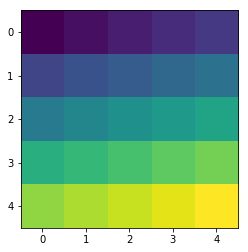

In [56]:
# pick a range
plt.imshow(np.arange(25).reshape(5,5))

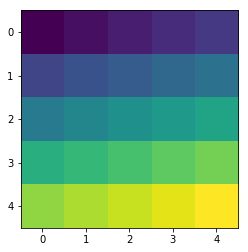

In [57]:
# shift it
plt.imshow(np.arange(25,50).reshape(5,5))

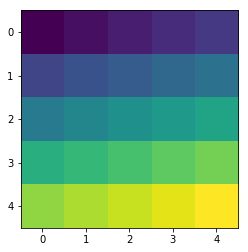

In [58]:
# scale it
plt.imshow(100*np.arange(25,50).reshape(5,5))

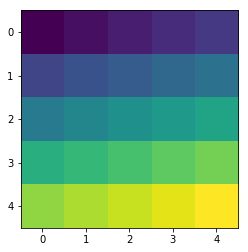

In [59]:
# fractions
plt.imshow(np.linspace(0,1,25).reshape(5,5))

It seems we can use this to plot our reward function. 

In [103]:
def plotR(R, h, w, title="", grid=None):
    
    R = np.asarray(R[:-1])
    R_max = R.max()
    R_min = R.min()
    
    if grid:
        R2 = []
        i = 0
        for r in range(len(grid)):
            for c in range(len(grid[0])):
                if grid[r][c] != GridWorld.MARKER_WALL:
                    R2.append(R[i])
                    i += 1
                else:
                    R2.append(-(R_max-R_min))
        R = np.asarray(R2)
    
    plt.imshow(R.reshape(h,w))
    plt.title(title)
    
def compare_grid_data(R1, R2, h, w, title1="Original", title2="Recovered", suffix="Reward", grid=None):
    
    plt.subplot(1,2,1)
    plotR(R1, h, w, title1+" "+suffix, grid)
    plt.subplot(1,2,2)
    plotR(R2, h, w, title2+" "+suffix, grid)

### Linear Rewards (Uses state features so that R = w.dot(fs))

In [80]:
test_grid2 = [[' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',+100]]

gw = GridWorld(test_grid2, gamma=0.99, action_noise_dist=[0., 1., 0.], living_reward=-0.1)
trajectories_mat = np.asarray(gw.sample_trajectories(1000, init_state_idx="random", max_length=15), dtype=np.int)
R = max_ent_irl(trajectories_mat, gw.get_state_grid_features_matrix(), gw.gamma, gw.nA, gw.T, 100, 0.1, silent=True)
vi = run_value_iteration(gw.T, R, gw.gamma)

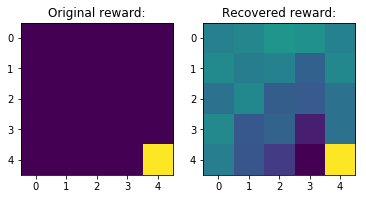

In [81]:
compare_grid_data(gw.R, R, gw.width, gw.height, suffix="reward:")

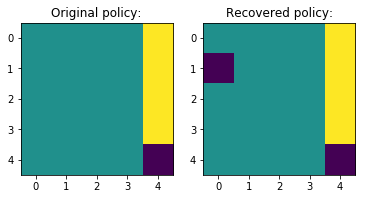

In [82]:
compare_grid_data(gw.vi_results.policy, vi.policy, gw.width, gw.height, suffix="policy:")

### Non-linear Rewards (Uses state features so that R != w.dot(fs))

In [84]:
R = max_ent_irl(trajectories_mat, gw.get_state_2d_features_matrix(), gw.gamma, gw.nA, gw.T, 100, 0.1, silent=True)
vi = run_value_iteration(gw.T, R, gw.gamma)

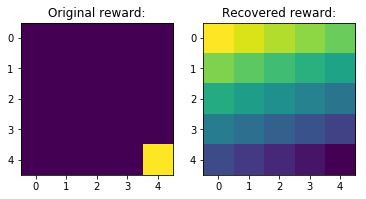

In [85]:
compare_grid_data(gw.R, R, gw.width, gw.height, suffix="reward:")

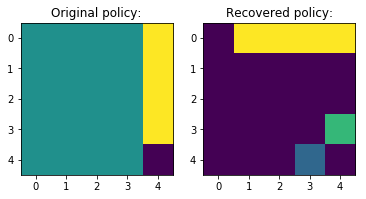

In [86]:
compare_grid_data(gw.vi_results.policy, vi.policy, gw.width, gw.height, suffix="policy:")

### R&N Chap. 17 Grid World, Linear Rewards

In [174]:
book_grid = [[' ',' ',' ',+1],
            [' ','#',' ',-1],
            ['@',' ',' ',' ']]

gw = GridWorld(book_grid, gamma=0.99, action_noise_dist=[0., 1., 0.], living_reward=-0.04)
trajectories_mat = np.asarray(gw.sample_trajectories(1000, init_state_idx="random", max_length=15), dtype=np.int)

epochs, lr = 400, 0.05
R = max_ent_irl(trajectories_mat, gw.get_state_grid_features_matrix(), gw.gamma, gw.nA, gw.T, epochs, lr, silent=True)
vi = run_value_iteration(gw.T, R, gw.gamma)

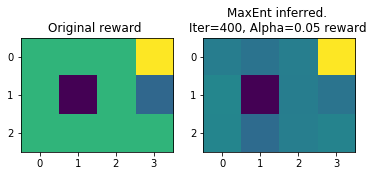

In [175]:
compare_grid_data(gw.R, R, gw.height, gw.width, suffix="reward ", title2="MaxEnt inferred. \nIter={}, Alpha={}".format(epochs, lr), grid=book_grid)

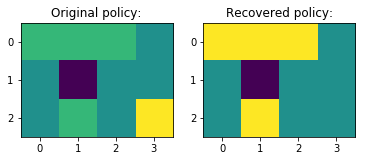

In [176]:
compare_grid_data(gw.vi_results.policy, vi.policy, gw.height, gw.width, suffix="policy:", grid=book_grid)

In [177]:
gw.disp_custom_grid(vi.policy, lambda x: "{:}".format(gw.actions_name[x]))

East	East	East	North	
North	-inf	North	North	
North	East	North	North	
Absorbing state: North


In [178]:
gw.disp_custom_grid(gw.vi_results.policy, lambda x: "{:}".format(gw.actions_name[x]))

East	East	East	North	
North	-inf	North	North	
North	East	North	West	
Absorbing state: North


### R&N Chap. 17 Grid World, Linear Rewards, +Stochasticity

In [179]:
book_grid = [[' ',' ',' ',+1],
            [' ','#',' ',-1],
            ['@',' ',' ',' ']]

gw = GridWorld(book_grid, gamma=0.99, action_noise_dist=[0.1, 0.8, 0.1], living_reward=-0.04)
trajectories_mat = np.asarray(gw.sample_trajectories(1000, init_state_idx="random", max_length=15), dtype=np.int)

epochs, lr = 400, 0.1
R = max_ent_irl(trajectories_mat, gw.get_state_grid_features_matrix(), gw.gamma, gw.nA, gw.T, epochs, lr, silent=True)
vi = run_value_iteration(gw.T, R, gw.gamma)

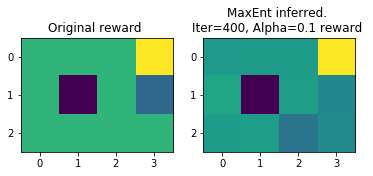

In [180]:
compare_grid_data(gw.R, R, gw.height, gw.width, suffix="reward ", title2="MaxEnt inferred. \nIter={}, Alpha={}".format(epochs, lr), grid=book_grid)

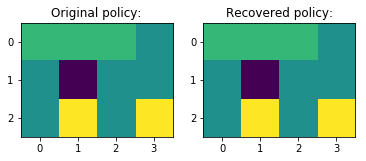

In [181]:
compare_grid_data(gw.vi_results.policy, vi.policy, gw.height, gw.width, suffix="policy:", grid=book_grid)

### R&N Chap. 17 Grid World, Non-linear Rewards

In [146]:
R = max_ent_irl(trajectories_mat, gw.get_state_2d_features_matrix(), gw.gamma, gw.nA, gw.T, epochs, lr, silent=True)
vi = run_value_iteration(gw.T, R, gw.gamma)

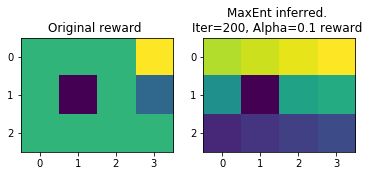

In [147]:
compare_grid_data(gw.R, R, gw.height, gw.width, suffix="reward ", title2="MaxEnt inferred. \nIter={}, Alpha={}".format(epochs, lr), grid=book_grid)

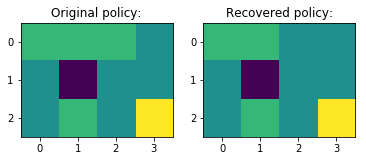

In [148]:
compare_grid_data(gw.vi_results.policy, vi.policy, gw.height, gw.width, suffix="policy:", grid=book_grid)

In [133]:
test_grid0 = [[0.1,0.1,0.1,0.1],
              [' ',' ',' ',' '],
            [' ',' ',' ',' ']]

test_grid1 = [[' ',' ',' ',+100],
            ['@','#',' ',' '],
            [' ',' ',' ',-100]]

test_grid2 = [[' ',' ',' ',' '],
            ['@',' ',' ',+100],
            [' ',' ',' ',' ']]

test_grid3 = [['@',' ',' ',+100],
            [' ',' ',' ',' '],
            [-100,' ',' ',' ']]

## References

1. Levine et al. "CS 294: Deep Reinforcement Learning." 2017. http://rll.berkeley.edu/deeprlcourse/
2. Ziebart, Brian D., et al. "Maximum Entropy Inverse Reinforcement Learning." AAAI. Vol. 8. 2008.
3. Matthew Alger's MaxEnt implementation. https://github.com/MatthewJA/Inverse-Reinforcement-Learning